# Quantized training bottleneck

In order to enable low-bit training, we need to understand which part of the process prevents training. This can be the forward pass, the backwards pass, or both.

We swap each part of the implementation individually with a floating point version and find the lowest bitwidth

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
import itertools
import pickle


from activations import *
import train_integers

%matplotlib notebook
%load_ext autoreload
%autoreload 2


def save_object(data, filename):
    with open(filename, 'wb') as output:
        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)
        
        
def load_object(filename):
    try:
        with open(filename, 'rb') as input:
            return pickle.load(input)
    except Exception as err: 
        print err
        return None
    

# button for hiding code
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# Here is a grid search of fraction widths and learning rates when both the forward pass and backwards pass are computed with fixed point values

<IPython.core.display.Javascript object>


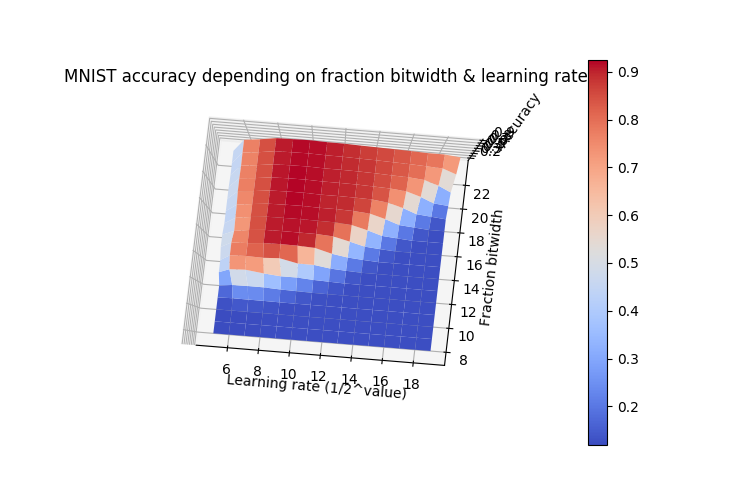

In [3]:
from sklearn.datasets import load_digits, fetch_mldata

mnist = fetch_mldata("MNIST original")
inputs = mnist.data / 255.0
targets = mnist.target

mnist_acc = load_object("mnist_accuracies.pickle")
if mnist_acc is not None:
    accuracies, learning_rates, fractions = mnist_acc
if mnist_acc is None: 
    accuracies = np.zeros((20 - 5, 24 - 8))
    learning_rates = np.zeros((20 - 5, 24 - 8))
    fractions = np.zeros((20 - 5, 24 - 8))
    for lr in range(5, 20):
        for fraction in range(8, 24):
            print("Fraction {}, LR {}".format(fraction, lr))
            acc = train_integers.test_classification(inputs, targets, fraction=fraction, lr=lr, 
                      conf=[784, 10], iter=10000, smooth_window=1001, func=relu, 
                      func_der=relu_derivative, verbosity="none")
            accuracies[lr - 5, fraction - 8] = acc[-1]
            learning_rates[lr - 5, fraction - 8] = lr
            fractions[lr - 5, fraction - 8] = fraction
    
    save_object((accuracies, learning_rates, fractions), "mnist_accuracies.pickle")

fig = plt.figure(figsize=(7.5, 5))
ax1 = fig.add_subplot(111, projection='3d')
surface = ax1.plot_surface(learning_rates, fractions, accuracies, cmap=matplotlib.cm.coolwarm, linewidth=1, antialiased=True)

# axis labels
ax1.set_xlabel("Learning rate (1/2^value)")
ax1.set_ylabel("Fraction bitwidth")
ax1.set_zlabel("Accuracy")
ax1.set_title("MNIST accuracy depending on fraction bitwidth & learning rate")

cbar = fig.colorbar(surface)


# And here is the same grid search when we use floating point values for the backwards pass

<IPython.core.display.Javascript object>


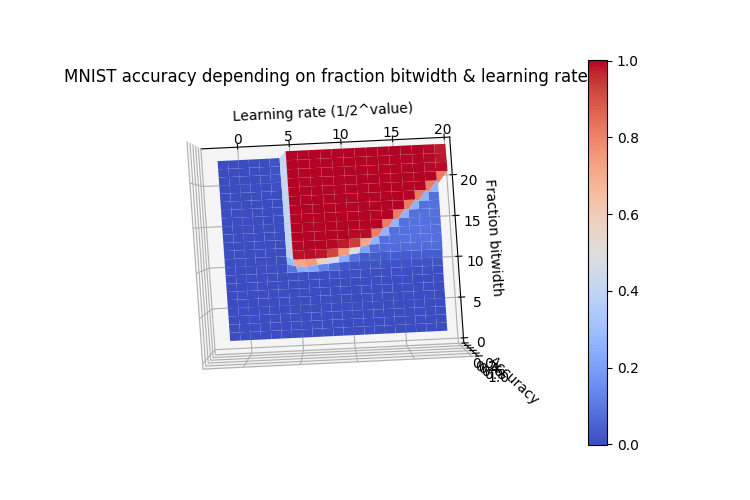

In [28]:
from sklearn.datasets import load_digits, fetch_mldata

mnist = fetch_mldata("MNIST original")
inputs = mnist.data / 255.0
targets = mnist.target

mnist_acc = load_object("mnist_bw_float_accuracies.pickle")
if mnist_acc is not None:
    accuracies, learning_rates, fractions = mnist_acc
if mnist_acc is None: 
    accuracies = np.zeros((20 + 2, 24 - 1))
    learning_rates = np.zeros((20 + 2, 24 - 1))
    fractions = np.zeros((20 + 2, 24 - 1))
    for lr in range(-2, 20):
        for fraction in range(1, 24):
            print("Fraction {}, LR {}".format(fraction, lr))
            acc = train_integers.test_classification(inputs, targets, fraction=fraction, lr=lr, 
                      conf=[784, 10], iter=10000, smooth_window=1001, func=relu, 
                      func_der=relu_derivative, verbosity="none")
            accuracies[lr + 2, fraction - 1] = acc[-1]
            learning_rates[lr + 2, fraction - 1] = lr
            fractions[lr + 2, fraction - 1] = fraction
    
    save_object((accuracies, learning_rates, fractions), "mnist_bw_float_accuracies.pickle")

fig = plt.figure(figsize=(7.5, 5))
ax1 = fig.add_subplot(111, projection='3d')
surface = ax1.plot_surface(learning_rates, fractions, accuracies, cmap=matplotlib.cm.coolwarm, linewidth=1, antialiased=True)

# axis labels
ax1.set_xlabel("Learning rate (1/2^value)")
ax1.set_ylabel("Fraction bitwidth")
ax1.set_zlabel("Accuracy")
ax1.set_title("MNIST accuracy depending on fraction bitwidth & learning rate")

cbar = fig.colorbar(surface)

# Lets also compare a full floating point implementation 

[Errno 2] No such file or directory: 'mnist_float_accuracies.pickle'
LR -2
LR -1
LR 0
LR 1
LR 2
LR 3
LR 4
LR 5
LR 6
LR 7
LR 8
LR 9
LR 10
LR 11
LR 12
LR 13
LR 14
LR 15
LR 16
LR 17
LR 18
LR 19


<IPython.core.display.Javascript object>


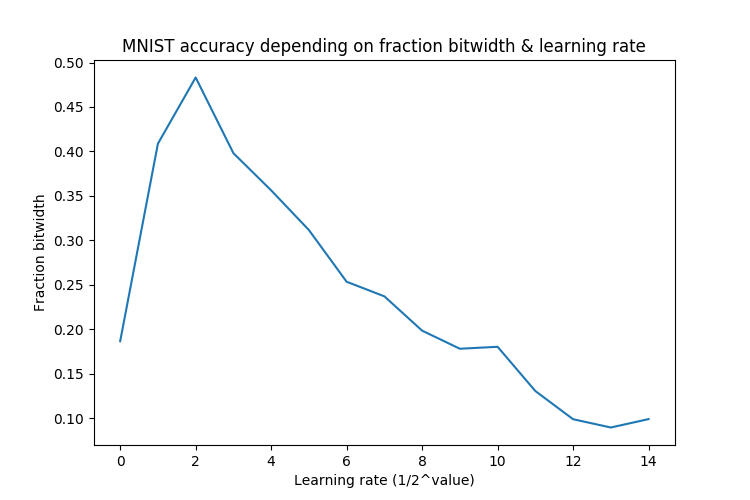

In [42]:
from sklearn.datasets import load_digits, fetch_mldata
reload(train_integers)

mnist = fetch_mldata("MNIST original")
inputs = mnist.data / 255.0
targets = mnist.target

mnist_acc = load_object("mnist_float_accuracies.pickle")
if mnist_acc is not None:
    accuracies, learning_rates = mnist_acc
if mnist_acc is None: 
    accuracies     = np.zeros(20 - 5)
    learning_rates = np.zeros(20 - 5)
    for lr in range(-2, 20):
        print("LR {}".format(lr))
        acc = train_integers.train_float_classification(inputs, targets, lr=lr, 
                  conf=[784, 10], iter=10000, weight_variance=0.1, smooth_window=1001, func=relu, 
                  func_der=relu_derivative, verbosity="none")
        accuracies[lr - 5] = acc[-1]
        learning_rates[lr - 5] = lr
    
    save_object((accuracies, learning_rates), "mnist_float_accuracies.pickle")

fig = plt.figure(figsize=(7.5, 5))
ax1 = fig.add_subplot(111)
surface = ax1.plot(accuracies)

# axis labels
ax1.set_xlabel("Learning rate (1/2^value)")
ax1.set_ylabel("Fraction bitwidth")
ax1.set_title("MNIST accuracy depending on fraction bitwidth & learning rate")


#  Lets see them side by side:

As we can see, the training is far more successful when using floating points, even though only for the backwards pass. 

<IPython.core.display.Javascript object>


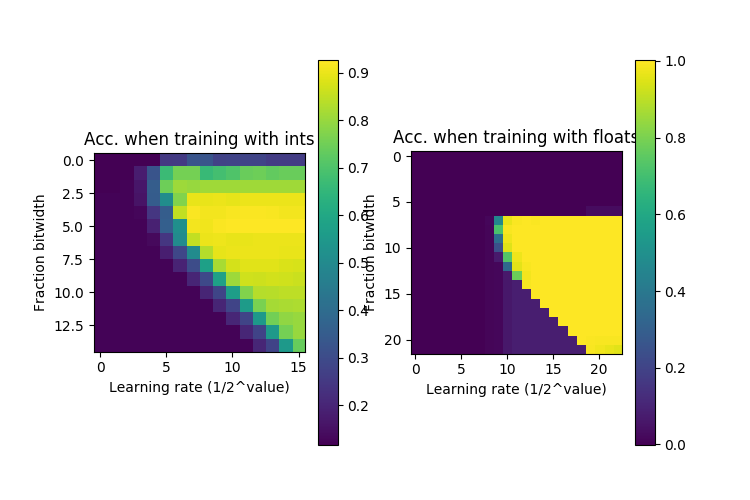

In [30]:
fixed_bw = load_object("mnist_accuracies.pickle")
float_bw = load_object("mnist_bw_float_accuracies.pickle")

fig = plt.figure(figsize=(7.5, 5))

# left figure
ax1 = fig.add_subplot(121)
surface = ax1.imshow(fixed_bw[0])
ax1.set_xlabel("Learning rate (1/2^value)")
ax1.set_ylabel("Fraction bitwidth")
#plt.xticks(np.arange(np.min(fixed_bw[1]), np.max(fixed_bw[1])+1, 1.0))
ax1.set_title("Acc. when training with ints")
cbar = fig.colorbar(surface)

# right figure
ax2 = fig.add_subplot(122)
surface = ax2.imshow(float_bw[0])
ax2.set_xlabel("Learning rate (1/2^value)")
ax2.set_ylabel("Fraction bitwidth")
#plt.xticks(np.arange(np.min(fixed_bw[1]), np.max(fixed_bw[1])+1, 1.0))
ax2.set_title("Acc. when training with floats")
cbar = fig.colorbar(surface)

In [24]:
float_bw[2]

array([[  8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
         19.,  20.,  21.,  22.,  23.],
       [  8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
         19.,  20.,  21.,  22.,  23.],
       [  8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
         19.,  20.,  21.,  22.,  23.],
       [  8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
         19.,  20.,  21.,  22.,  23.],
       [  8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
         19.,  20.,  21.,  22.,  23.],
       [  8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
         19.,  20.,  21.,  22.,  23.],
       [  8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
         19.,  20.,  21.,  22.,  23.],
       [  8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
         19.,  20.,  21.,  22.,  23.],
       [  8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
         19.,  20.,  2